# Customer Health/Risk Score Project

Author: Lavinia Wang <br>
@Showpad

This project aims to use Showpad customers' (legal) profile(historical data) to build statistical models that will help understand:
- What patterns indicate customer will churn
- How likely the customer is going to churn
- What score the customer should be labeled in terms of risk to churn

Methods:
- Logistic regression
- Decision Tree

In [1]:
## Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn import preprocessing

In [2]:
## Load file into pandas
## Data starts in row #5
df = pd.read_csv("/Users/liyan.wang/Desktop/Customer Health Score/Metadata SFDC (customers active at Feb2018) - Main.csv", header=0)
df = df[4:].reset_index(drop=True)
#df

In [3]:
df.shape

(1087, 41)

In [4]:
df.describe(include="O")

,Customer Name,SFDC Account ID,Account Status,Okay for Speech API Rollout?,Current Location (primary),Current Location (secondary),Filename (primary),Filename (secondary),Initial Term Start Date,Initial Term Length,...,Account Contract End Date,Account Owner,Customer Success Coach,Expected Renewal ARR * Currency,Package,Assigned users,Segment,Billing State/Province,Billing Country,Hoovers Industry
count,1087,1087,1087,1087,1069,724,1065,720,1080,1080,...,1079,1087,1072,1087,1087,1087,1087,523,1086,330
unique,1087,1087,12,8,1027,678,1028,676,658,19,...,350,36,20,3,5,134,2,82,41,138
top,Premier Companies UK,001D000001RgVV1,Active Customer - Content,ok,Conga-SAI-00654,Box: RestrictedLegal/Contract/Customer Contrac...,Saint-Gobain SSA 30nov2015,Arval Service Lease SA SO 21dec2017,31Dec2017,12,...,31/12/2018,Bartel Van Herreweghe,Celine Vincent,EUR,Essential,100,MM,California,United States,Medical Equipment & Supplies Manufacturing
freq,1,1,711,821,23,20,23,20,42,992,...,85,238,321,642,623,385,834,65,301,28


In [5]:
## Look at descriptive statistics of numeric variables
df.describe()

,Expected Renewal ARR *,N° of Licenses,Used Licenses,Employees,Fortune Rank
count,1087.000000,1087.000000,1087.000000,725.000000,56.000000
mean,21767.509126,114.708372,95.949402,10218.663448,214.035714
std,44749.374503,400.164184,367.383186,33080.652847,307.364395
min,-679.350000,0.000000,0.000000,0.000000,0.000000
25%,3000.000000,10.000000,7.000000,100.000000,0.000000
50%,8400.000000,25.000000,19.000000,430.000000,0.000000
75%,21627.500000,65.000000,54.000000,3800.000000,416.000000
max,725400.000000,7500.000000,7228.000000,219678.000000,948.000000


In [6]:
## Ouput column names for future use
df.columns

Index(['Customer Name', 'SFDC Account ID', 'Account Status',
       'Okay for Speech API Rollout?', 'Current Location (primary)',
       'Current Location (secondary)', 'Filename (primary)',
       'Filename (secondary)', 'Initial Term Start Date',
       'Initial Term Length', 'Auto-renewal', 'Termination Rights',
       'Marketing', 'Non-Solicit Obligations', 'Legal Terms and Conditions',
       'SLA', 'DPA', 'Privacy Policy Change Notice Requirement',
       'Data or Security Breach Notice Requirement',
       'Change of Control provision', 'Governing Law',
       'Notable Non-Standard Terms', 'Outrageous Terms',
       'Expected Renewal ARR * (converted) Currency',
       'Expected Renewal ARR * (converted)', 'Account Status.1',
       'Account Contract End Date', 'Account Owner', 'Customer Success Coach',
       'Expected Renewal ARR * Currency', 'Expected Renewal ARR *', 'Package',
       'N° of Licenses', 'Used Licenses', 'Assigned users', 'Segment',
       'Employees', 'Fortune

## Variable Exploration 

Explore distribution of various levels in each categorical variable that should be used in the model

In [7]:
## Function that takes dataframe group by each categorical column/variable
## Output a table shows grouping numbers by different levels and a bar chart to visualize

def exploration(data, variable):
    lst = data.groupby(by=variable).count()
    lst = lst['SFDC Account ID']
    print(lst)
    lst.plot.bar()  

In [8]:
#c_Speech_API_Rollout = exploration(df,'Okay for Speech API Rollout?')
#c_Initial_Term_Length = exploration(df,'Initial Term Length')
#c_Auto_renewal = exploration(df, 'Auto-renewal')
#c_Termination_Rights = exploration(df,'Termination Rights')
#c_Marketing = exploration(df,'Marketing')
#c_Non_Solicit_Obligations = exploration(df,'Non-Solicit Obligations')
#c_Legal_Terms_Conditions = exploration(df, 'Legal Terms and Conditions')
#c_SLA = exploration(df,'SLA')
#c_DPA = exploration(df,'DPA')
#c_Privacy_Change_Notice = exploration(df,'Privacy Policy Change Notice Requirement')
#c_Data_Security_Breach_Notice = exploration(df,'Data or Security Breach Notice Requirement')
#c_Control_provision = exploration(df,'Change of Control provision')
#c_Governing_Law = exploration(df,'Governing Law')
#c_Outrageous_Terms = exploration(df,'Outrageous Terms')
#c_account = exploration(df,'Account Status')
#c_Account_Owner = exploration(df,'Account Owner')
#c_Customer_Success_Coach = exploration(df,'Customer Success Coach')
#c_Package = exploration(df,'Package')
#c_Segment = exploration(df,'Segment')

<b>After disucssion with legal team @6/27/2019 3:30:-4:30 pm CST, 'Account status' is selected as dependent/outcome variable. Therefore this is a typical prediction problem for calculating probability of an instance (churn) and feature selected can be used for interpretation. </b>
    
1. Transformation need to be done:
    - Remove varibales irrevelant to model building, which are: 'SFDC Account ID','Current Location (primary)', 'Current Location (secondary)', 'Filename (primary)', 'Filename (secondary)',  'Account Contract End Date', 'Account Owner', 'Customer Success Coach', 'Fortune Rank', 'Billing State/Province', 'Billing Country', 'Hoovers Industry'
    - Remove rows with missing or irrelevant values(consent with legal team)
    - Transform 'Initial term start date' into 'Duration', which is calculated from initial term start date and use today's date as the end date.
    - Group/bin variables into a more standard format, e.g 'Auto-renewal' 
    - Convert 'Notable Non-standard Terms' and 'Outrageous Terms' into a binary answer question, i.e. any filled-in contents is considered 'Yes' and no is 'No'
    - Convert currency into a uniformed format, i.e. use 'Expected Renewal ARR *' of its own currency to generate renewal ARR in EUR 
    - Follow up with @Joy on how to group variables 'Okay for Speech API Rollout' and 'Governing Law'

2. Create dummy variables for all revelant categorical variables
3. Normalize data for modeling

## Transformation

- <b>Remove irrelevant variables from dataframe</b>

In [9]:
df_copy = df.drop(labels=['SFDC Account ID','Current Location (primary)', 'Current Location (secondary)', 
                          'Filename (primary)', 'Filename (secondary)', 'Expected Renewal ARR * (converted) Currency',
                          'Expected Renewal ARR * (converted)', 'Account Status.1', 'Account Contract End Date', 
                          'Account Owner','Customer Success Coach', 'Fortune Rank', 'Billing State/Province', 
                          'Billing Country', 'Hoovers Industry'], axis=1)
#df_copy.head()

- <b>Remove irrelevant account status from dataframe</b>

In [167]:
## Remove rows from dataframe where account status are:
## Active Customer - Reverse Ghost     27
## Ghost Active - Content               2
## Ghost Churned                        3
## Lead Partner                         1
## Prospect                            16
## Sandbox                              1

remove_list = ['Active Customer - Reverse Ghost', 'Ghost Active - Content', 'Ghost Churned', 'Lead Partner', 
              'Prospect', 'Sandbox']

for i in range(len(remove_list)):
    df_copy = df_copy[df_copy['Account Status'] != remove_list[i]]

#df_copy
## There are 1037 rows left

- <b> Remove rows with null in 'Initial Term Start Date' </b>

In [11]:
null_row = df_copy[df_copy['Initial Term Start Date'].isnull()]
null_row

,Customer Name,Account Status,Okay for Speech API Rollout?,Initial Term Start Date,Initial Term Length,Auto-renewal,Termination Rights,Marketing,Non-Solicit Obligations,Legal Terms and Conditions,...,Notable Non-Standard Terms,Outrageous Terms,Expected Renewal ARR * Currency,Expected Renewal ARR *,Package,N° of Licenses,Used Licenses,Assigned users,Segment,Employees
964,Technology Association of Oregon,Churned Customer,ok,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,USD,0.0,Essential,2.0,2.0,100,MM,12.0


In [12]:
df_copy = df_copy[df_copy['Customer Name'] != 'Technology Association of Oregon']
df_copy = df_copy.reset_index(drop=True)

In [13]:
df_copy.shape

(1036, 26)

- <b>Change 'Initial term start date' into 'Duration' then bin the variable</b>

In [14]:
df_copy['start_date'] = pd.to_datetime(df_copy['Initial Term Start Date'])

In [15]:
## Use strftime (string format time) to get string mm/dd/yyyy instead of the datetime object
import datetime as dt
end_date = dt.datetime.today().strftime("%m/%d/%Y")
end_date = pd.to_datetime(end_date)
end_date = [end_date for i in range (len(df_copy))]
df_copy['end_date'] = end_date
#df_copy.head()

In [16]:
## Create new variable called Duration representing 
## how long the customer has been with Showpad
diff = (df_copy['end_date']- df_copy['start_date']).dt.days
diff = diff.apply(lambda x : int(x))
df_copy['duration'] = diff.astype(int)
#diff.describe()

In [166]:
#df_copy

- <b>Group/bin variables</b>

1. 'Okay for Speech API Rollout?'

In [18]:
## 1: OK, 2: Hold for Special Notice, 3: Hold for Consent

ok_list = ['OK-2', 'OK-3', 'OK-4', 'OK-DPA', 'ok', 'ok-5']

tmp = df_copy['Okay for Speech API Rollout?']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] in ok_list:
        tmp[i] = '1'
    elif tmp[i] == 'Hold for Special Notice':
        tmp[i] = '2'
    else: # tmp[i] == 'Hold for Consent'
        tmp[i] = '3'
           
speech_api_rollout = pd.DataFrame(tmp)
df_copy['speech_api_rollout'] = speech_api_rollout
#df_copy.tail(20)

2. 'Initial Term Length'

In [19]:
## Customer: Dawn Capital is a partner with content in this field 'trial'
## Remove row of 'Dawn Capital' from data
## Create 4 equal width bins: (0,12],(12,24], (24,36],(36,48]

tmp = df_copy['Initial Term Length']
tmp = tmp.apply(lambda x: int(x))
bins = [0, 12, 24, 36, 48]
tmp_bin = pd.cut(tmp, bins).astype(str)
#tmp_bin

for i in range (tmp.size):
    if tmp_bin[i] == '(0,12]':
        tmp_bin[i] = '1'
    elif tmp_bin[i] == '(12,24]':
        tmp_bin[i] = '2'
    elif tmp_bin[i] == '(24,36]':
        tmp_bin[i] = '3'
    else: # tmp[i] == '(36,48]'
        tmp_bin[i] = '4'
           

df_copy['term_length'] = tmp_bin
#df_copy.head()

3. Auto-renewal

In [20]:
yes_30_list = ['Yes', 'Yes ', 'Yes (30-day opt out)', 'Yes (30-day opt-out)', 'yes (30-day opt-out)',
               'Yes (Custom- written confirmation; 30-day opt-out)', 'Yes (custom opt-out)', 
               'Yes (custom-30-day opt-out)', 'Yes (written agreement)', 'Yes (written notice)']
yes_30_more_list = ['Yes (3-month opt-out)', 'Yes (90-day opt-out)', 'Yes (90-day notification & 30-day opt-out)']
yes_30_less_list = ['Yes (1-day opt-out)', 'Yes (5-day opt-out)']
no_list = ['No', 'No (written agreement)', 'No (written notice required)']
## 1: 'No', 2: 'Yes - 30-day notice', 3:' Yes - less than 30-day notice', 4: 'Yes - greater than 30-day notice'

tmp = df_copy['Auto-renewal']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] in yes_30_list:
        tmp[i] = '2'
    elif tmp[i] in yes_30_less_list:
        tmp[i] = '3'
    elif tmp[i] in yes_30_more_list:
        tmp[i] = '4'
    else: 
        tmp[i] = '1'
    
auto_renewal = pd.DataFrame(tmp)
df_copy['auto_renewal'] = auto_renewal
#df_copy.head(30)

4. 'Termination Rights'

In [21]:
yes_90_less_list = ['Yes', 'Yes (30 days)', 'Yes (5 days)', 'Yes (60-day notice)', 'Yes (Custom)', 'Yes (first 3 months)',
              'Yes (written notice)', 'Yes - 30-day notice', 'Yes- Two Months Notice', 'Yes-Custom']
yes_90_or_more_list = ['Yes (90-day notice)', 'Yes - 90-day notice']
## 1:'No', 2: 'Yes - less than 90-day notice', 3: 'Yes - at least 90-day notice'

tmp = df_copy['Termination Rights']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] in yes_90_less_list:
        tmp[i] = '2'
    elif tmp[i] in yes_90_or_more_list:
        tmp[i] = '3'
    else: 
        tmp[i] = '1'
    
termination_rights = pd.DataFrame(tmp)
df_copy['termination_rights'] = termination_rights
#df_copy.tail(30)

5. 'Marketing' 

In [22]:
prohibition_list = ['Affirmative Prohibition', 'Affirmative prohibition', 
                    "Referral Partner requires Showpad's approval", 'No']
silent_list = ['Silent', 'Silent ', 'Silent or Soft Commitment', 'Silent or Soft Commitment ', 'Silent or Soft Support']
reference_list = ['Agreed to provide marketing support']
enhanced_list = ['Enhanced marketing commitment']
## 1: 'Affirmative prohibition', 2: 'Silent', 3: 'Basic permission to reference as a customer', 
## 4:'Enhanced marketing commitment'

tmp = df_copy['Marketing']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] in prohibition_list:
        tmp[i] = '1'
    elif tmp[i] in silent_list:
        tmp[i] = '2'
    elif tmp[i] in reference_list:
        tmp[i] = '3'    
    else: 
        tmp[i] = '4'
        
marketing = pd.DataFrame(tmp)
df_copy['marketing'] = marketing
#df_copy.head(5)

6. 'Non-Solicit Obligations'

In [23]:
yes_list = ['Yes', 'Yes - 1 year']

tmp = df_copy['Non-Solicit Obligations']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] in yes_list:
        tmp[i] = '1'
    else:
        tmp[i] = '0'
        
obligations = pd.DataFrame(tmp)
df_copy['obligations'] = obligations
#df_copy.head()

7. 'Legal Terms and Conditions'

In [24]:
## 1: 'Custom', 2: 'Standard (MSA 2018v2)', 3: 'Standard (MSA 1Apr18)', 4: 'Standard (3Apr17)', 
## 5: 'Standard (15Nov16)', 6: 'Standard (pre-15Nov16)'

tmp = df_copy['Legal Terms and Conditions']
tmp = np.array(tmp)

custom_list = ['Custom (amended Standard (15nov2016 - 31mar2017))', 'Custom']

for i in range (tmp.size):
    if tmp[i] in custom_list :
        tmp[i] = '1'
    elif tmp[i] == 'Standard (MSA 2018v2)':
        tmp[i] = '2'
    elif tmp[i] == 'Standard (MSA 01apr2018)': 
        tmp[i] = '3'
    elif tmp[i] == 'Standard (03apr2017-31mar2018)':
        tmp[i] = '4'
    elif tmp[i] == 'Standard (15nov2016 - 31mar2017)':
        tmp[i] = '5'
    else: #tmp[i] == 'Standard (pre-15nov2016)':
        tmp[i] = '6'
        
legal_terms = pd.DataFrame(tmp)
df_copy['legal_terms'] = legal_terms
#df_copy.head()    

8. 'SLA' 

In [25]:
custom_list = ['Yes', 'Yes ', 'Yes (Custom)', 'Yes (custom)', 'Yes (unknown)', 'Yes (updated time to time)']
std_2016_list = ['Yes (Standard SLA Nov2016)']
std_2015_list = ['Yes (Standard SLA 2015)', 'Yes (standard SLA 2015)']
## 1: 'No', 2: 'Custom', 3: 'Standard (Nov2016)', 4: 'Standard (2015)'

tmp = df_copy['SLA']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] == 'No':
        tmp[i] = '1'
    elif tmp[i] in custom_list:
        tmp[i] = '2'
    elif tmp[i] in std_2016_list:
        tmp[i] = '3'
    elif tmp[i] in std_2015_list: 
        tmp[i] = '4'
    
sla = pd.DataFrame(tmp)
df_copy['sla'] = sla
#df_copy.head()

9. 'DPA'

In [26]:
## Change yes to 1 and no to 0
tmp = df_copy['DPA']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] == 'Yes':
        tmp[i] = '1'
    else:
        tmp[i] = '0'
        
dpa = pd.DataFrame(tmp)
df_copy['dpa'] = dpa
#df_copy.head()

10. 'Privacy Policy Change Notice Requirement'

In [27]:
## Convert blank to 'No' 
## 1: 'No', 2: 'Notice and Opportunity to Object', 3: 'Passive Notice'
tmp = df_copy['Privacy Policy Change Notice Requirement']
for i in range (len(tmp)):
    if pd.isnull(tmp[i]) or tmp[i] == 'No':
        tmp[i] = '1'
        
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] == 'Affirmative Opt-in or Amendment' or tmp[i] == 'Provide Opportunity to Review and Object':
        tmp[i] = '2'
    elif tmp[i] == 'Publication of Privacy Policy': 
        tmp[i] = '3'
        
prvcy_change_note = pd.DataFrame(tmp)
df_copy['prvcy_change_note'] = prvcy_change_note
#df_copy.tail(20)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


11. 'Data or Security Breach Notice Requirement'

In [28]:
w_24_list = ['24 Hours', 'Yes (12 hours)', 'Yes (24 hours)', 'Yes (ASAP)', 'Yes (Immediately)', 'Yes (immediate)',
             'Yes (immediately)', 'Yes (within 24 hours of discovery)', 'Yes- immediate notice of CI loss']
w_48_list = ['Yes', 'Yes ', 'Yes (2 business days)', 'Yes (48 hours)', 'Yes (Custom)', 
             'Yes (Within 48 hours of discovery)', 'Yes (custom)', 'Yes (undefined)', 
             'Yes (immediate, within 48 hours)']
m_48_list = ['Yes (72 hours)', 'Yes (Without Undue Delay)', 'Yes (within 72 hours of discovery)']
## 1: 'No', 2: 'Yes - within 24 hours of discovery', 3: 'Yes - between 24-48 hours after discovery',
## 4: 'Yes - greater than 48 hours after discovery'

tmp = df_copy['Data or Security Breach Notice Requirement']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] in w_24_list:
        tmp[i] = '2'
    elif tmp[i] in w_48_list:
        tmp[i] = '3'
    elif tmp[i] in m_48_list:
        tmp[i] = '4'
    else: 
        tmp[i] = '1'
          
sec_breach_note = pd.DataFrame(tmp)
df_copy['sec_breach_note'] = sec_breach_note
#df_copy.tail(20)

12. 'Change of Control provision'

In [29]:
## Change yes to 1 and no to 0
tmp = df_copy['Change of Control provision']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] == 'Yes':
        tmp[i] = '1'
    else:
        tmp[i] = '0'
        
tmp = tmp.T
cntrl_prvsn = pd.DataFrame(tmp)
df_copy['cntrl_prvsn'] = cntrl_prvsn
#df_copy.head()

13. 'Governing Law'

In [30]:
tmp = df_copy['Governing Law']
tmp = np.array(tmp)

CA_list = ['California', 'California ']
USA_rest_list = ['Florida', 'Georgia',  'Indiana', 'Nevada', 'New Jersey',  'Pennsylvania', 'Wisconsin', 'None']
Germany_list = ['Germany', 'German']
EU_rest_list = ['England', 'England & Wales', 'England and Wales', 'England/Wales', 'English', 'UK', 'Dutch',
                'Switzerland' ]
## Ideal grouping creteria:
## 1: New York,  2: Delaware, 3: California, 4: Illinois, 5: Texas, 6: Belgium, 7: Ireland, 8: France, 9: Germany, 
## 10: rest of the states in the USA, 11: rest of the countries in the EU
## Since there are only 2 records of Germany, I will change it into group 11 unless we have more data  

for i in range (tmp.size):
    if tmp[i] == 'New York':
        tmp[i] = '1'
    elif tmp[i] == 'Delaware':
        tmp[i] = '2'
    elif tmp[i] in CA_list:
        tmp[i] = '3'
    elif tmp[i] == 'Illinois':
        tmp[i] = '4'
    elif tmp[i] == 'Texas':
        tmp[i] = '5'
    elif tmp[i] == 'Belgium':
        tmp[i] = '6'
    elif tmp[i] == 'Ireland':
        tmp[i] = '7'
    elif tmp[i] == 'France':
        tmp[i] = '8'
    #elif tmp[i] in Germany_list:
        #tmp[i] = '9'
    elif tmp[i] in USA_rest_list:
        tmp[i] = '10'  
    elif tmp[i] in EU_rest_list or tmp[i] in Germany_list:
        tmp[i] = '11'
                
govn_law = pd.DataFrame(tmp)
df_copy['govn_law'] = govn_law
#df_copy.tail(20)   

14. 'Notable Non-Standard Terms'

In [31]:
## 'Not an actual customer' treat as blank
## Change yes or any content to 1 and no or blank to 0
tmp = df_copy['Notable Non-Standard Terms']

for i in range (len(tmp)):
    if pd.isnull(tmp[i]) or tmp[i] == 'Not an actual customer' or tmp[i] == 'No':
        tmp[i] = '0'

tmp = np.array(tmp)
#print(tmp)

for i in range (tmp.size):
    if tmp[i] != '0':
        tmp[i] = '1'
        
non_std_terms = pd.DataFrame(tmp)
#df_copy.head(20)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


15. 'Outrageous Terms'

In [32]:
## Change yes or any content to 1 and no or blank to 0
tmp = df_copy['Outrageous Terms']

for i in range (len(tmp)):
    if pd.isnull(tmp[i]) or tmp[i] == 'No':
        tmp[i] = '0'

tmp = np.array(tmp)
#print(tmp)

for i in range (tmp.size):
    if tmp[i] != '0':
        tmp[i] = '1'
        
outrageous = pd.DataFrame(tmp)
#df_copy.head(20)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
## Combine 'Notable Non-Standard Terms' and 'Outrageous Terms'
non_std_outrageous = np.array(pd.concat([non_std_terms, outrageous], axis=1)).astype(int)

s = [non_std_outrageous[i][0] for i in range (len(non_std_outrageous))]
n = 0

for i in range (len(s)):
    for j in range (2):
        n += non_std_outrageous[i][j]
    s[i] = n
    n = 0    

In [34]:
combined_terms = s.copy()
for i in range (len(combined_terms)):
    if combined_terms[i] == 0:
        combined_terms[i] = '0'
    else: combined_terms[i] = '1'

In [36]:
df_copy['non_std_outrageous'] = combined_terms

16. 'Account Status'

In [37]:
## Change status from string to numeric representation 
## 1 = Churned/Locked, 0 = Active

tmp = df_copy['Account Status']
tmp = np.array(tmp)

active_list = ['Active Customer - Coach', 'Active Customer - Content', 'Active Customer - Platform']
churn_list = ['Active Customer - Churned', 'Active Customer - locked', 'Churned Customer']

for i in range (len(tmp)):
    if tmp[i] in churn_list:
        tmp[i] = '1'
    else: 
        tmp[i] = '0'
           
status = pd.DataFrame(tmp).astype(int)
df_copy['status'] = status
#df_copy.head()  

17. 'Expected Renewal ARR * Currency' & 'Expected Renewal ARR *'

In [38]:
## Convert GBP and USD to EUR
## 6/28 curency rate
## 1 USD = 0.88 EUR
## 1 GBP = 1.12 EUR
tmp = df_copy[['Expected Renewal ARR * Currency', 'Expected Renewal ARR *']]
tmp = np.array(tmp)

for i in range (len(tmp)):
    if tmp[i][0] == 'GBP':
        tmp[i][0] = 'EUR'
        tmp[i][1] = tmp[i][1] * 1.12
    elif tmp[i][0] == 'USD':
        tmp[i][0] = 'EUR'
        tmp[i][1] = tmp[i][1] * 0.88
           
renewal_ARR = pd.DataFrame(tmp)
renewal_ARR = renewal_ARR[1]
renewal_ARR = renewal_ARR.apply(lambda x: int(x))

df_copy['renewal_ARR'] = renewal_ARR

18. 'Package'

In [39]:
tmp = df_copy['Package']
tmp = np.array(tmp)
## 1: Enterprise, 2: Essential, 3: Plus, 4: Professional, 5: Ultimate

for i in range (len(tmp)):
    if tmp[i] == 'Enterprise':
        tmp[i] = '1'
    elif tmp[i] == 'Essential':
        tmp[i] = '2'
    elif tmp[i] == 'Plus':
        tmp[i] = '3'
    elif tmp[i] == 'Professional':
        tmp[i] = '4'
    else: tmp[i] = '5'

package = pd.DataFrame(tmp)
df_copy['package'] = package

19. 'Assigned users'

In [40]:
tmp = df_copy['Assigned users']
assigned_user = tmp.apply(lambda x: int(x))

df_copy['assigned_user'] = assigned_user

20.'Segment'

In [41]:
## Change ENT to 1 and MM to 0
tmp = df_copy['Segment']
tmp = np.array(tmp)

for i in range (tmp.size):
    if tmp[i] == 'ENT':
        tmp[i] = '1'
    else:
        tmp[i] = '0'
        
segment = pd.DataFrame(tmp)
df_copy['segment'] = segment
#df_copy.head()

21. 'Employees'

In [42]:
## Fill in missing value with median instaed of mean 
## because the range of this varibale is so large 
## mean is obviously skewed by large values/max
tmp = np.array([df_copy['Employees']])
tmp = tmp.T

imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
emp = imp_freq.fit_transform(tmp)
#print(emp)

employees_trans = pd.DataFrame(emp)

df_copy['employees_trans'] = employees_trans

- <b>Create dataframe for binned variables</b>

In [43]:
df_copy.columns

Index(['Customer Name', 'Account Status', 'Okay for Speech API Rollout?',
       'Initial Term Start Date', 'Initial Term Length', 'Auto-renewal',
       'Termination Rights', 'Marketing', 'Non-Solicit Obligations',
       'Legal Terms and Conditions', 'SLA', 'DPA',
       'Privacy Policy Change Notice Requirement',
       'Data or Security Breach Notice Requirement',
       'Change of Control provision', 'Governing Law',
       'Notable Non-Standard Terms', 'Outrageous Terms',
       'Expected Renewal ARR * Currency', 'Expected Renewal ARR *', 'Package',
       'N° of Licenses', 'Used Licenses', 'Assigned users', 'Segment',
       'Employees', 'start_date', 'end_date', 'duration', 'speech_api_rollout',
       'term_length', 'auto_renewal', 'termination_rights', 'marketing',
       'obligations', 'legal_terms', 'sla', 'dpa', 'prvcy_change_note',
       'sec_breach_note', 'cntrl_prvsn', 'govn_law', 'non_std_outrageous',
       'status', 'renewal_ARR', 'package', 'assigned_user', 'segmen

In [44]:
## Select transformed variables(binned) into a new dataframe
bin_df = df_copy[['speech_api_rollout', 'duration', 'term_length', 'auto_renewal', 'termination_rights', 'marketing',
                  'obligations', 'legal_terms', 'sla', 'dpa', 'prvcy_change_note', 'sec_breach_note', 'cntrl_prvsn',
                  'govn_law', 'non_std_outrageous', 'status', 'renewal_ARR', 'package',
                  'N° of Licenses', 'Used Licenses', 'assigned_user', 'segment', 'employees_trans']]
#bin_df
# 1079 rows × 24 columns

- <b>Seperate dependent and indepednet variables</b>

In [45]:
x = bin_df.drop('status',axis = 1)
y = bin_df['status']
print( 'x shape is: ', x.shape, 'y shape is: ', y.shape)

x shape is:  (1036, 22) y shape is:  (1036,)


- <b>Create train and test set split at 80/20</b>

In [131]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=11)

print('x_train shape is: ', x_train.shape, 'y_train shape is: ', y_train.shape)
print('x_test shape is: ', x_test.shape, 'y_test shape is: ', y_test.shape)

x_train shape is:  (694, 22) y_train shape is:  (694,)
x_test shape is:  (342, 22) y_test shape is:  (342,)


- <b>Use decision tree for first time variable screening</b>

In [132]:
from sklearn import tree, naive_bayes
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

treeclf = tree.DecisionTreeClassifier()
treeclf = treeclf.fit(x_train, y_train)

#print (treeclf.score(x_train, y_train))
#print (treeclf.score(x_test, y_test))
#print (treeclf.feature_importances_)

```
[0.         0.19700966 0.         0.01064737 0.00417484 0.
 0.00488562 0.01361773 0.01431099 0.         0.00446889 0.
 0.         0.02445029 0.007693   0.29901837 0.03741115 0.06871739
 0.10201073 0.06390945 0.00808897 0.13958554]
 ```
From the above decision tree feature importance table, we can be sure that only 16 out of 22 variables are significant, which are:
<b>
1. duration
2. auto_renewal 
3. termination_rights
4. obligations
5. legal_terms
6. sla
7. prvcy_change_note
8. govn_law 
9. non_std_outrageous 
10. renewal_ARR
11. package
12. N° of Licenses
13. Used Licenses
14. assigned_user 
15. segment 
16. employees_trans 
    
Discuss with legal team and agree to remove govn_law from independent variable list.
</b>

- <b> Normalize numeric variables</b>

In [133]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_norm = min_max_scaler.fit_transform(x_train[['duration','renewal_ARR','N° of Licenses', 'Used Licenses',
                                              'assigned_user', 'employees_trans']])
x_test_norm = min_max_scaler.fit_transform(x_test[['duration','renewal_ARR','N° of Licenses', 'Used Licenses',
                                              'assigned_user', 'employees_trans']])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [134]:
new_x_train = pd.DataFrame(x_train_norm, columns = ['duration','renewal_ARR','N° of Licenses', 'Used Licenses',
                                                    'assigned_user', 'employees_trans'])
new_x_test = pd.DataFrame(x_test_norm, columns = ['duration','renewal_ARR','N° of Licenses', 'Used Licenses',
                                                    'assigned_user', 'employees_trans'])

- <b>Create dummy variables</b>

In [135]:
x_train_dummy = pd.get_dummies(x_train[['auto_renewal', 'termination_rights', 'obligations', 'legal_terms', 'sla',
                                        'prvcy_change_note', 'non_std_outrageous', 'package', 'segment']]).reset_index(drop=True)
x_test_dummy = pd.get_dummies(x_test[['auto_renewal', 'termination_rights', 'obligations', 'legal_terms', 'sla',
                                        'prvcy_change_note', 'non_std_outrageous', 'package', 'segment']]).reset_index(drop=True)

- <b> Combine two dataframes into one for modeling </b>

In [136]:
x_train_frame = pd.concat([x_train_dummy, new_x_train], axis=1)
x_test_frame = pd.concat([x_test_dummy, new_x_test], axis=1)

In [139]:
X_train = np.array(x_train_frame)
X_test = np.array(x_test_frame)

Y_train = np.array(y_train)
Y_test = np.array(y_test)

In [140]:
print('After transformation and feature selection, x_train shape is:', X_train.shape)
print('After transformation and feature selection, x_test shape is:', X_test.shape)
print('After transformation and feature selection, y_train shape is:', Y_train.shape)
print('After transformation and feature selection, y_test shape is:', Y_test.shape)

After transformation and feature selection, x_train shape is: (694, 36)
After transformation and feature selection, x_test shape is: (342, 36)
After transformation and feature selection, y_train shape is: (694,)
After transformation and feature selection, y_test shape is: (342,)


## Modeling

- <b>Model 1 using default settings</b>

In [141]:
from sklearn.linear_model import LogisticRegression
logisticRegr1 = LogisticRegression(solver='lbfgs')

m1 = logisticRegr1.fit(X_train, Y_train)
predictions_logRegr1 = logisticRegr1.predict(X_test)

In [142]:
# Use score method to get accuracy of model
score1 = logisticRegr1.score(X_test, Y_test)
print('Accuracy is %.4f'% score1)

Accuracy is 0.7310


This method is using L2 penalty (aka Ridge by adding “squared magnitude” of coefficient as penalty term to the loss function).

In [143]:
from sklearn import metrics
cm1 = metrics.confusion_matrix(Y_test, predictions_logRegr1, labels=[1,0])
print(cm1)

[[ 13  77]
 [ 15 237]]


In [144]:
print(classification_report(Y_test, predictions_logRegr1))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84       252
           1       0.46      0.14      0.22        90

   micro avg       0.73      0.73      0.73       342
   macro avg       0.61      0.54      0.53       342
weighted avg       0.68      0.73      0.68       342



- <b>Model 2 using L1 penalty</b>

In [145]:
logisticRegr2 = LogisticRegression(penalty='l1', solver='saga')

m2 = logisticRegr2.fit(X_train, Y_train)
predictions_logRegr2 = logisticRegr2.predict(X_test)

score2 = logisticRegr2.score(X_test, Y_test)
print('Accuracy is %.4f'% score2)

cm2 = metrics.confusion_matrix(Y_test, predictions_logRegr2, labels=[1,0])
print(cm2)

print(classification_report(Y_test, predictions_logRegr2))

Accuracy is 0.7398
[[ 12  78]
 [ 11 241]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.84       252
           1       0.52      0.13      0.21        90

   micro avg       0.74      0.74      0.74       342
   macro avg       0.64      0.54      0.53       342
weighted avg       0.69      0.74      0.68       342



This method is using L1 penalty (aka LASSO by adding “absolute value of magnitude” of coefficient as penalty term to the loss function).

- <b>Model 3 using decsion tree 'entropy' as measurement</b>

In [146]:
treeclf1 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=3)
treeclf1 = treeclf.fit(X_train, Y_train)

predictions_tree1 = treeclf1.predict(X_test)

score3 = treeclf1.score(X_test, Y_test)
print('Accuracy is %.4f'% score3)

cm3 = confusion_matrix(Y_test, predictions_tree1, labels=[1,0])
print (cm3)

print(classification_report(Y_test, predictions_tree1))

Accuracy is 0.5673
[[ 58  32]
 [116 136]]
              precision    recall  f1-score   support

           0       0.81      0.54      0.65       252
           1       0.33      0.64      0.44        90

   micro avg       0.57      0.57      0.57       342
   macro avg       0.57      0.59      0.54       342
weighted avg       0.68      0.57      0.59       342



This method is using 'entropy' as measurement. 

- <b>Model 4 using decsion tree 'gini' as measurement</b>

In [147]:
treeclf2 = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=3)
treeclf2 = treeclf.fit(X_train, Y_train)

predictions_tree2 = treeclf2.predict(X_test)

score4 = treeclf2.score(X_test, Y_test)
print('Accuracy is %.4f'% score4)

cm4 = confusion_matrix(Y_test, predictions_tree2, labels=[1,0])
print (cm4)

print(classification_report(Y_test, predictions_tree2))

Accuracy is 0.6023
[[ 56  34]
 [102 150]]
              precision    recall  f1-score   support

           0       0.82      0.60      0.69       252
           1       0.35      0.62      0.45        90

   micro avg       0.60      0.60      0.60       342
   macro avg       0.58      0.61      0.57       342
weighted avg       0.69      0.60      0.63       342



<b>Comparing the results from models, logistic regression with L1 penalty has the best performace(accuracy). So we will choose this model for final score computation.

Text(0.5, 257.44, 'Predicted label')

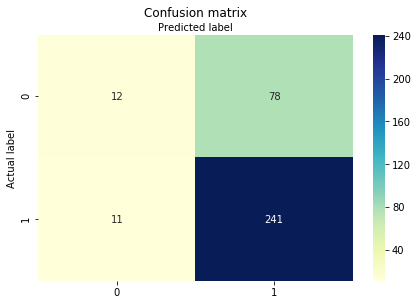

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

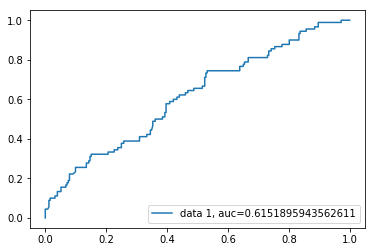

In [149]:
y_pred_proba = logisticRegr2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AUC score for the case is 0.61. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

In [150]:
print(logisticRegr2.coef_)
print(logisticRegr2.intercept_)

[[ 0.00000000e+00  7.55138615e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -4.02405281e-01 -4.14050363e-01
   1.03924123e+00  0.00000000e+00  3.51741017e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.22757899e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.73001838e-01
   0.00000000e+00 -6.44071438e-03  4.70317338e-01 -1.06135595e+00
  -2.38488594e-01  8.65017854e-04  0.00000000e+00 -6.23430728e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  5.21937655e-01]]
[-0.93978167]


In [151]:
## Probalility of getting 1 i.e churn
prob_test_1 = logisticRegr2.predict_proba(X_test)[:,1]
#prob_test_1

In [152]:
x_train_frame.columns

Index(['auto_renewal_1', 'auto_renewal_2', 'auto_renewal_3', 'auto_renewal_4',
       'termination_rights_1', 'termination_rights_2', 'termination_rights_3',
       'obligations_0', 'obligations_1', 'legal_terms_1', 'legal_terms_3',
       'legal_terms_4', 'legal_terms_5', 'legal_terms_6', 'sla_1', 'sla_2',
       'sla_3', 'sla_4', 'prvcy_change_note_1', 'prvcy_change_note_2',
       'prvcy_change_note_3', 'non_std_outrageous_0', 'non_std_outrageous_1',
       'package_1', 'package_2', 'package_3', 'package_4', 'package_5',
       'segment_0', 'segment_1', 'duration', 'renewal_ARR', 'N° of Licenses',
       'Used Licenses', 'assigned_user', 'employees_trans'],
      dtype='object')

In [153]:
prob_train_1 = logisticRegr2.predict_proba(X_train)[:,1]
#prob_train_1

## Validation

In [154]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(m2, x, y, cv=10)
cv_scores
print("Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Overall Accuracy: 0.71 (+/- 0.02)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Application

In [155]:
p_test_1 = pd.DataFrame(prob_test_1)
p_train_1 = pd.DataFrame(prob_train_1)
p_1 = pd.concat([p_test_1, p_train_1])
p_1 = p_1.reset_index(drop=True)
p_1 = np.array(p_1)

p = [p_1[i][0] for i in range (len(p_1))]
p = np.array(p)

In [156]:
p_score = pd.qcut(p, 5)
p_score

[(0.285, 0.302], (0.302, 0.399], (0.244, 0.285], (0.302, 0.399], (0.244, 0.285], ..., (0.302, 0.399], (0.399, 0.793], (0.244, 0.285], (0.244, 0.285], (0.302, 0.399]]
Length: 1036
Categories (5, interval[float64]): [(-0.000545, 0.244] < (0.244, 0.285] < (0.285, 0.302] < (0.302, 0.399] < (0.399, 0.793]]

In [157]:
x_name = df_copy['Customer Name']
x_train_name, x_test_name = train_test_split(x_name, test_size=0.33, random_state=11)
#x_train_name

- <b>Apply score back to train set</b>

In [158]:
p_train_bin = np.array(p_train_1)
p_train_bin = [p_train_bin[i][0] for i in range (len(p_train_bin))]
new_bins = [-0.000545, 0.244, 0.285, 0.302, 0.399, 0.793]
p_train_bin = pd.cut(p_train_bin, new_bins).astype(str)

for i in range (len(p_train_bin)):
    if p_train_bin[i] == '(-0.000545, 0.244]':
        p_train_bin[i] = '1'
    elif p_train_bin[i] == '(0.244, 0.285]':
        p_train_bin[i] = '2'
    elif p_train_bin[i] == '(0.285, 0.302]':
        p_train_bin[i] = '3'
    elif p_train_bin[i] == '(0.302, 0.399]':
        p_train_bin[i] = '4'
    else: #p_train_bin[i] == '(0.399, 0.793]':
        p_train_bin[i] = '5'

#p_train_bin        

In [159]:
x_train_new = pd.DataFrame()
x_train_new['customer name'] = x_train_name
x_train_new = x_train_new.reset_index(drop=True)
x_train_new['prob'] = p_train_1
x_train_new['score'] = p_train_bin
#x_train_new

- <b>Apply score back to test set</b>

In [160]:
p_test_bin = np.array(p_test_1)
p_test_bin = [p_test_bin[i][0] for i in range (len(p_test_bin))]
p_test_bin = pd.cut(p_test_bin, new_bins).astype(str)

for i in range (len(p_test_bin)):
    if p_test_bin[i] == '(-0.000545, 0.244]':
        p_test_bin[i] = '1'
    elif p_test_bin[i] == '(0.244, 0.285]':
        p_test_bin[i] = '2'
    elif p_test_bin[i] == '(0.285, 0.302]':
        p_test_bin[i] = '3'
    elif p_test_bin[i] == '(0.302, 0.399]':
        p_test_bin[i] = '4'
    else: #p_train_bin[i] == '(0.399, 0.793]':
        p_test_bin[i] = '5'

In [161]:
x_test_new = pd.DataFrame()
x_test_new['customer name'] = x_test_name
x_test_new = x_test_new.reset_index(drop=True)
x_test_new['prob'] = p_test_1
x_test_new['score'] = p_test_bin
#x_train_new

In [165]:
combined = pd.concat([x_train_new, x_test_new], ignore_index=True)
combined = combined.sort_values(by=['customer name'])
combined = combined.reset_index(drop=True)
#combined

In [163]:
score_group = combined.groupby(by='score').count()
score_group

,customer name,prob
score,,
1,207,207
2,212,212
3,207,207
4,203,203
5,207,207


In [164]:
combined.to_csv('Customer Health Score.csv', index=False)